In [1]:
import wandb
import composuite
from diffusion.utils import *
from diffusion.elucidated_diffusion import Trainer
from diffusion.train_diffuser import SimpleDiffusionGenerator

gin.parse_config_file("/home/anhquanpham/projects/compositional-rl-synth-data/config/diffusion.gin")

base_data_path = '/home/anhquanpham/projects/data'
base_results_folder = '/home/anhquanpham/projects/results'
#device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
def remove_indicator_vectors(modality_dims, dataset):

    dataset = dataset.copy()

    start_index = sum([dim[0] for key, dim in modality_dims.items() if key in ['object-state', 'obstacle-state', 'goal-state']])
    end_index = start_index + sum([dim[0] for key, dim in modality_dims.items() if key in ['object_id', 'robot_id', 'obstacle_id', 'subtask_id']])

    def remove_indicator_dims(data, start, end):
        indicators_ = data[:, start:end]
        data_ = np.delete(data, np.arange(start, end), axis=1)
        return data_, indicators_

    observations, obs_indicators = remove_indicator_dims(dataset['observations'], start_index, end_index)
    dataset['observations'] = observations
    next_observations, _ = remove_indicator_dims(dataset['next_observations'], start_index, end_index)
    dataset['next_observations'] = next_observations
    
    return dataset, obs_indicators

In [3]:
dataset_type = 'expert'

robot = 'IIWA'
obj = 'Box'
obst = 'None'
task = 'PickPlace'

results_folder = os.path.join(base_results_folder, robot + '_' + obj + '_' + obst + '_' + task)



env = composuite.make(robot, obj, obst, task, use_task_id_obs=True, ignore_done=False)
dataset = load_single_composuite_dataset(base_path=base_data_path, 
                                         dataset_type=dataset_type, 
                                         robot=robot, obj=obj, 
                                         obst=obst, task=task)
dataset = transitions_dataset(dataset)

print('Before removing task indicators:', dataset['observations'].shape)
dataset, indicators = remove_indicator_vectors(env.modality_dims, dataset)
print('After removing task indicators:', dataset['observations'].shape, indicators.shape)
print(env.modality_dims)

print(dataset.keys())  # Should still contain 'observations' and 'next_observations'




/home/anhquanpham/.pyenv/versions/first_3.9.6/lib/python3.9/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Before removing task indicators: (999999, 93)
After removing task indicators: (999999, 77) (999999, 16)
{'object-state': (14,), 'obstacle-state': (14,), 'goal-state': (17,), 'object_id': (4,), 'robot_id': (4,), 'obstacle_id': (4,), 'subtask_id': (4,), 'robot0_proprio-state': (32,)}
dict_keys(['observations', 'actions', 'next_observations', 'rewards', 'terminals'])


In [7]:
# print("Observations shape:", dataset['observations'][0].shape)
# print("Actions shape:", dataset['actions'][0].shape)
# print("Next Observations shape:", dataset['next_observations'][0].shape)
# print("Rewards shape:", dataset['rewards'][0].shape)
# print("Terminals shape:", dataset['terminals'][0].shape)

In [9]:
# print("Observations shape:", dataset['observations'][0])
# print("Actions shape:", dataset['actions'][0])
# print("Next Observations shape:", dataset['next_observations'][0])
# print("Rewards shape:", dataset['rewards'][0])
# print("Terminals shape:", dataset['terminals'][0])

In [11]:
inputs = make_inputs(dataset)
print(inputs[0].shape) # 164 = 77 + 8 + 1 + 77 + 1 #STATE + ACTION + REWARD + NEXT STATE + TERMINAL, formatted in make_inputs

(164,)


In [13]:
inputs = torch.from_numpy(inputs).float()
indicators = torch.from_numpy(indicators).float()
dataset = torch.utils.data.TensorDataset(inputs, indicators)

In [15]:
# print("Observations:", inputs[0, :77])  # First 77 columns (observations)
# print("Actions:", inputs[0, 77:85])     # Columns 77 to 84 (actions)
# print("Reward:", inputs[0, 85])         # Column 85 (reward)
# print("Next Observations:", inputs[0, 86:163])  # Columns 86 to 162 (next observations)
# print("Terminals:", inputs[0, -1])      # Last column (terminal state, if modelled_terminals=True)

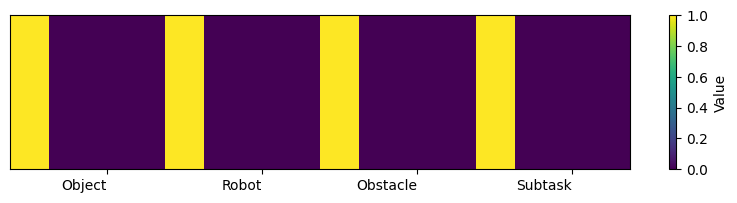

In [17]:
idx = 0
import matplotlib.pyplot as plt

task_vector = indicators[idx, :].reshape(1, -1)

labels = ['Object', 'Robot', 'Obstacle', 'Subtask']
plt.figure(figsize=(10, 2))
plt.imshow(task_vector, cmap="viridis", aspect="auto")
plt.colorbar(label="Value")
plt.xticks(ticks=[2, 6, 10, 14], labels=labels, ha='right')
plt.yticks([])
plt.show()

In [19]:
# observation_positions = {
#     'object-state': np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), 
#     'obstacle-state': np.array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]), 
#     'goal-state': np.array([28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
#     'robot0_proprio-state': np.array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
#         62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]),
#     'object_id': np.array([77, 78, 79, 80]), 
#     'robot_id': np.array([81, 82, 83, 84]), 
#     'obstacle_id': np.array([85, 86, 87, 88]), 
#     'subtask_id': np.array([89, 90, 91, 92])
# }


# sizes = ((32,), (32, 32), (64, 64, 64), (64, 64, 64))
# module_names = ["obstacle_id", "object_id", "subtask_id", "robot_id"]
# module_input_names = ["obstacle-state", "object-state", "goal-state", "robot0_proprio-state"]

# module_assignment_positions = [observation_positions[key] for key in module_names]
# interface_depths = [-1, 1, 2, 3]
# graph_structure = [[0], [1], [2], [3]]
# num_modules = [len(onehot_pos) for onehot_pos in module_assignment_positions]

# module_inputs = []
# for key in module_input_names:
#     if isinstance(key, list):
#         # concatenate the inputs
#         module_inputs.append(
#             np.concatenate([observation_positions[k] for k in key], axis=0)
#         )
#     else:
#         module_inputs.append(observation_positions[key])

# # Initial weight initialization (optional)
# init_w = 3e-3

# # Activation functions
# hidden_activation = nn.ReLU  # Example hidden activation
# output_activation = nn.Identity  # No output activation

# # Layer normalization (optional)
# layer_norm = False  # You can set this to True if needed
# layer_norm_kwargs = None  # Custom kwargs if any
# obs_dim = 93
# act_dim = 8
# output_dim = 77
# observation_shape = (93,)

# encoder_kwargs = {
#         "sizes": sizes,
#         "obs_dim": obs_dim,
#         "output_dim": output_dim if output_dim is not None else act_dim,
#         "num_modules": num_modules,
#         "module_assignment_positions": module_assignment_positions,
#         "module_inputs": module_inputs,
#         "interface_depths": interface_depths,
#         "graph_structure": graph_structure,
#     }

In [21]:
# def fanin_init(tensor):
#     """Initialize the weights of a layer with fan-in initialization.

#     Args:
#         tensor (torch.Tensor): Tensor to initialize.

#     Returns:
#         torch.Tensor: Initialized tensor.

#     Raises:
#         Exception: If the shape of the tensor is less than 2.
#     """
#     size = tensor.size()
#     if len(size) == 2:
#         fan_in = size[0]
#     elif len(size) > 2:
#         fan_in = np.prod(size[1:])
#     else:
#         raise Exception("Shape must be have dimension at least 2.")
#     bound = 1.0 / np.sqrt(fan_in)
#     return tensor.data.uniform_(-bound, bound)

In [23]:
# from typing import Optional, Sequence, Dict, Any
# from abc import ABCMeta, abstractmethod

# class _VectorEncoder(nn.Module):  # type: ignore

#     _observation_shape: Sequence[int]
#     _use_batch_norm: bool
#     _dropout_rate: Optional[float]
#     _use_dense: bool
#     _activation: nn.Module
#     _feature_size: int
#     _fcs: nn.ModuleList
#     _bns: nn.ModuleList
#     _dropouts: nn.ModuleList

#     def __init__(
#         self,
#         observation_shape: Sequence[int],
#         hidden_units: Optional[Sequence[int]] = None,
#         use_batch_norm: bool = False,
#         dropout_rate: Optional[float] = None,
#         use_dense: bool = False,
#         activation: nn.Module = nn.ReLU(),
#     ):
#         super().__init__()
#         self._observation_shape = observation_shape

#         if hidden_units is None:
#             hidden_units = [256, 256]

#         self._use_batch_norm = use_batch_norm
#         self._dropout_rate = dropout_rate
#         self._feature_size = hidden_units[-1]
#         self._activation = activation
#         self._use_dense = use_dense

#         in_units = [observation_shape[0]] + list(hidden_units[:-1])
#         self._fcs = nn.ModuleList()
#         self._bns = nn.ModuleList()
#         self._dropouts = nn.ModuleList()
#         for i, (in_unit, out_unit) in enumerate(zip(in_units, hidden_units)):
#             if use_dense and i > 0:
#                 in_unit += observation_shape[0]
#             self._fcs.append(nn.Linear(in_unit, out_unit))
#             if use_batch_norm:
#                 self._bns.append(nn.BatchNorm1d(out_unit))
#             if dropout_rate is not None:
#                 self._dropouts.append(nn.Dropout(dropout_rate))

#     def _fc_encode(self, x: torch.Tensor) -> torch.Tensor:
#         h = x
#         for i, fc in enumerate(self._fcs):
#             if self._use_dense and i > 0:
#                 h = torch.cat([h, x], dim=1)
#             h = self._activation(fc(h))
#             if self._use_batch_norm:
#                 h = self._bns[i](h)
#             if self._dropout_rate is not None:
#                 h = self._dropouts[i](h)
#         return h

#     def get_feature_size(self) -> int:
#         return self._feature_size

#     @property
#     def observation_shape(self) -> Sequence[int]:
#         return self._observation_shape

#     @property
#     def last_layer(self) -> nn.Linear:
#         return self._fcs[-1]

# class Encoder(metaclass=ABCMeta):
#     @abstractmethod
#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         pass

#     @abstractmethod
#     def get_feature_size(self) -> int:
#         pass

#     @property
#     def observation_shape(self) -> Sequence[int]:
#         pass

#     @abstractmethod
#     def __call__(self, x: torch.Tensor) -> torch.Tensor:
#         pass

#     @property
#     def last_layer(self) -> nn.Linear:
#         raise NotImplementedError

# class CompositionalMlp(nn.Module):
#     """Compositional MLP module."""

#     def __init__(
#         self,
#         sizes: Sequence[Sequence[int]],
#         num_modules: Sequence[int],
#         module_assignment_positions: Sequence[int],
#         module_inputs: Sequence[str],
#         interface_depths: Sequence[int],
#         graph_structure: Sequence[Sequence[int]],
#         init_w: float = 3e-3,
#         hidden_activation: nn.Module = nn.ReLU,
#         output_activation: nn.Module = nn.Identity,
#         hidden_init: Optional[nn.Module] = fanin_init,
#         b_init_value: float = 0.1,
#         layer_norm: bool = False,
#         layer_norm_kwargs: Optional[dict] = None,
#     ):
#         """Initialize the compositional MLP module.

#         Args:
#             sizes (list): List of sizes of each layer.
#             num_modules (list): List of number of modules of each type.
#             module_assignment_positions (list): List of module assignment positions.
#             module_inputs (list): List of module inputs.
#             interface_depths (list): List of interface depths.
#             graph_structure (list): List of graph structures.
#             init_w (float, optional): Initial weight value. Defaults to 3e-3.
#             hidden_activation (nn.Module, optional): Hidden activation module. Defaults to nn.ReLU.
#             output_activation (nn.Module, optional): Output activation module. Defaults to nn.Identity.
#             hidden_init (function, optional): Hidden initialization function. Defaults to fanin_init.
#             b_init_value (float, optional): Initial bias value. Defaults to 0.1.
#             layer_norm (bool, optional): Whether to use layer normalization. Defaults to False.
#             layer_norm_kwargs (dict, optional): Keyword arguments for layer normalization. Defaults to None.
#         """
#         super().__init__()

#         if layer_norm_kwargs is None:
#             layer_norm_kwargs = dict()

#         self.sizes = sizes
#         self.num_modules = num_modules
#         self.module_assignment_positions = module_assignment_positions
#         self.module_inputs = module_inputs  # keys in a dict
#         self.interface_depths = interface_depths
#         self.graph_structure = (
#             graph_structure  # [[0], [1,2], 3] or [[0], [1], [2], [3]]
#         )
#         self.hidden_activation = hidden_activation
#         self.output_activation = output_activation
#         self.layer_norm = layer_norm
#         self.fcs = []
#         self.layer_norms = []
#         self.count = 0

#         self.module_list = nn.ModuleList()  # e.g., object, robot, task...

#         for graph_depth in range(
#             len(graph_structure)
#         ):  # root -> children -> ... leaves
#             for j in graph_structure[
#                 graph_depth
#             ]:  # loop over all module types at this depth
#                 self.module_list.append(nn.ModuleDict())  # pre, post
#                 self.module_list[j]["pre_interface"] = nn.ModuleList()
#                 self.module_list[j]["post_interface"] = nn.ModuleList()
#                 for k in range(num_modules[j]):  # loop over all modules of this type
#                     layers_pre = []
#                     layers_post = []
#                     for i in range(
#                         len(sizes[j]) - 1
#                     ):  # loop over all depths in this module
#                         if i == interface_depths[j]:
#                             input_size = sum(
#                                 sizes[j_prev][-1]
#                                 for j_prev in graph_structure[graph_depth - 1]
#                             )
#                             input_size += sizes[j][i]
#                         else:
#                             input_size = sizes[j][i]

#                         fc = nn.Linear(input_size, sizes[j][i + 1])
#                         if (
#                             graph_depth < len(graph_structure) - 1
#                             or i < len(sizes[j]) - 2
#                         ):
#                             hidden_init(fc.weight)
#                             fc.bias.data.fill_(b_init_value)
#                             act = hidden_activation
#                             layer_norm_this = layer_norm
#                         else:
#                             fc.weight.data.uniform_(-init_w, init_w)
#                             fc.bias.data.uniform_(-init_w, init_w)
#                             act = output_activation
#                             layer_norm_this = None

#                         if layer_norm_this is not None:
#                             new_layer = [fc, nn.LayerNorm(sizes[j][i + 1]), act()]
#                         else:
#                             new_layer = [fc, act()]

#                         if i < interface_depths[j]:
#                             layers_pre += new_layer
#                         else:
#                             layers_post += new_layer
#                     if layers_pre:
#                         self.module_list[j]["pre_interface"].append(
#                             nn.Sequential(*layers_pre)
#                         )
#                     else:  # it's either a root or a module with no preprocessing
#                         self.module_list[j]["pre_interface"].append(nn.Identity())
#                     self.module_list[j]["post_interface"].append(
#                         nn.Sequential(*layers_post)
#                     )

#     def forward(self, input_val: torch.Tensor, return_preactivations: bool = False):
#         """Forward pass.

#         Args:
#             input_val (torch.Tensor): Input tensor.
#             return_preactivations (bool, optional): Whether to return preactivations. Defaults to False.

#         Returns:
#             torch.Tensor: Output tensor.
#         """
#         if len(input_val.shape) > 2:
#             input_val = input_val.squeeze(0)

#         if return_preactivations:
#             raise NotImplementedError("TODO: implement return preactivations")
#         x = None
#         for graph_depth in range(
#             len(self.graph_structure)
#         ):  # root -> children -> ... -> leaves
#             x_post = []  # in case multiple module types at the same depth in the graph
#             for j in self.graph_structure[graph_depth]:  # nodes (modules) at this depth
#                 if len(input_val.shape) == 1:
#                     x_pre = input_val[self.module_inputs[j]]
#                     onehot = input_val[self.module_assignment_positions[j]]
#                     #print("j", j)
#                     #print("One hot: ", onehot)
#                     module_index = onehot.nonzero()[0]
#                     #print(f"module_index: {module_index}")
#                     #print(f"module_index type: {type(module_index)}")
#                     # Ensure module_index is a scalar integer
#                     #module_index = module_index.item()  # Access the first element if it's an array
#                     #print(f"module_index after fix: {module_index}")  # Verify the type and value
#                     #print("What is it trying to choose from: ",self.module_list[j]["pre_interface"])
#                     x_pre = self.module_list[j]["pre_interface"][module_index](x_pre)
#                     if x is not None:
#                         x_pre = torch.cat((x, x_pre), dim=-1)
#                     x_post.append(
#                         self.module_list[j]["post_interface"][module_index](x_pre)
#                     )
#                 else:
#                     x_post_tmp = torch.empty(input_val.shape[0], self.sizes[j][-1]).to(
#                         device #JUST FIXED CAPITAL DEVICE TO NORMAL DEVICE
#                     )
#                     x_pre = input_val[:, self.module_inputs[j]]
#                     onehot = input_val[:, self.module_assignment_positions[j]]
#                     module_indices = onehot.nonzero(as_tuple=True)
#                     assert (
#                         module_indices[0]
#                         == torch.arange(module_indices[0].shape[0]).to(device) #JUST FIXED CAPITAL DEVICE TO NORMAL DEVICE
#                     ).all()
#                     module_indices_1 = module_indices[1]
#                     for module_idx in range(self.num_modules[j]):
#                         mask_inputs_for_this_module = module_indices_1 == module_idx
#                         mask_to_input_idx = mask_inputs_for_this_module.nonzero()
#                         x_pre_this_module = self.module_list[j]["pre_interface"][
#                             module_idx
#                         ](x_pre[mask_inputs_for_this_module])
#                         if x is not None:
#                             x_pre_this_module = torch.cat(
#                                 (x[mask_inputs_for_this_module], x_pre_this_module),
#                                 dim=-1,
#                             )
#                         x_post_this_module = self.module_list[j]["post_interface"][
#                             module_idx
#                         ](x_pre_this_module)
#                         mask_to_input_idx = mask_to_input_idx.expand(
#                             mask_to_input_idx.shape[0], x_post_this_module.shape[1]
#                         )
#                         x_post_tmp.scatter_(0, mask_to_input_idx, x_post_this_module)
#                     x_post.append(x_post_tmp)
#             x = torch.cat(x_post, dim=-1)
#         return x

# class _CompositionalEncoder(_VectorEncoder):  # type: ignore
#     """_CompositionalEncoder class for d3rlpy."""

#     def __init__(
#         self,
#         encoder_kwargs: dict,
#         observation_shape: Sequence[int],
#         init_w: float = 3e-3,
#         *args,
#         **kwargs,
#     ):
#         """Initialize _CompositionalEncoder class.

#         Args:
#             encoder_kwargs (dict): Encoder parameters.
#             observation_shape (Sequence[int]): Observation shape.
#             init_w (float, optional): Initial weight. Defaults to 3e-3.
#         """
#         super().__init__(
#             observation_shape,
#             hidden_units=None,
#             use_batch_norm=False,
#             dropout_rate=None,
#             use_dense=False,
#             activation=nn.ReLU(),
#         )

#         self._observation_shape = observation_shape
#         self.encoder_kwargs = encoder_kwargs
#         sizes = encoder_kwargs["sizes"]
#         output_dim = encoder_kwargs["output_dim"]
#         num_modules = encoder_kwargs["num_modules"]
#         module_assignment_positions = encoder_kwargs["module_assignment_positions"]
#         module_inputs = encoder_kwargs["module_inputs"]
#         interface_depths = encoder_kwargs["interface_depths"]
#         graph_structure = encoder_kwargs["graph_structure"]
#         sizes = list(sizes)
#         for j in range(len(sizes)):
#             input_size = len(module_inputs[j])
#             sizes[j] = [input_size] + list(sizes[j])
#             if j in graph_structure[-1]:
#                 sizes[j] = sizes[j] + [output_dim]

#         self._feature_size = sizes[-1][-1]

#         self.comp_mlp = CompositionalMlp(
#             sizes=sizes,
#             num_modules=num_modules,
#             module_assignment_positions=module_assignment_positions,
#             module_inputs=module_inputs,
#             interface_depths=interface_depths,
#             graph_structure=graph_structure,
#             init_w=init_w,
#         )

#     def _fc_encode(self, x: torch.Tensor) -> torch.Tensor:
#         return self.comp_mlp.forward(x)

#     @property
#     def last_layer(self) -> nn.Linear:
#         raise NotImplementedError("CompositionalEncoder does not have last_layer")


# class CompositionalEncoder(_CompositionalEncoder, Encoder):
#     """Implements the actual Compositional Encoder."""

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         """Simply runs the forward pass from _CompositionalEncoder.

#         Args:
#             x (torch.Tensor): Input tensor.

#         Returns:
#             torch.Tensor: Output tensor.
#         """
#         return self._fc_encode(x)


In [25]:
# # Initialize Compositional Encoder
# compositional_encoder = CompositionalEncoder(
#     encoder_kwargs=encoder_kwargs,
#     observation_shape=observation_shape,      # Shape of the observation (input data)
# )

In [27]:

# # Simulate a batch with size 10 and each input having a shape of [164]
# test_group = 2


# # Additional tensor (with shape [16]) that needs to be concatenated
# additional_tensor = torch.tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])  # Shape: [16]

# # Expand additional_tensor to match the batch size
# additional_tensor_expanded = additional_tensor.unsqueeze(0).expand(test_group, -1)  # Shape: [10, 16]

# print("Additional tensor expanded", additional_tensor_expanded.shape)

# # Concatenate along the last dimension (dim=-1)
# data_pass = torch.cat([inputs[0:2], additional_tensor_expanded], dim=-1)  # Shape: [10, 180]

# # Check results
# print("Data pass shape:", data_pass.shape)  # Should be [10, 180]

In [29]:
# print(inputs[:,:77].shape)
# print(inputs[:, 77:85].shape)
# print(inputs[:, 85].shape)
# print(inputs[:, 86:163].shape)
# print(inputs[:,-1].shape)
# print(inputs[0][-1].shape)
# print("Observations:", inputs[0, :77])  # First 77 columns (observations)
# print("Actions:", inputs[0, 77:85])     # Columns 77 to 84 (actions)
# print("Reward:", inputs[0, 85])         # Column 85 (reward)
# print("Next Observations:", inputs[0, 86:163])  # Columns 86 to 162 (next observations)
# print("Terminals:", inputs[0, -1])  

In [31]:
# def forward_MLP(x):
#     # Initialize Compositional Encoder
#     compositional_encoder = CompositionalEncoder(
#     encoder_kwargs=encoder_kwargs,
#     observation_shape=observation_shape,
#     )      # Shape of the observation (input data)

#     current_state = x[:77]
#     action = x[77:85]
#     reward = x[85]
#     next_state = x[86:163]
#     terminal_flag = x[163]
#     onehot = x[164:180]
#     #print(onehot)

#     current_state_with_onehot = torch.cat([current_state, onehot])
#     #print("Cur_state onehot", current_state_with_onehot.shape)
#     next_state_with_onehot = torch.cat([next_state, onehot])

#     current_state_embedding = compositional_encoder(current_state_with_onehot)
#     next_state_embedding = compositional_encoder(next_state_with_onehot)

#     print("Original input shape: ", x.shape)
#     print("Current state orginal shape: ", current_state.shape)
#     print("Next state original shape: ", next_state.shape)

    
#     print("Current state embedding: ", current_state_embedding.shape)
#     print("Action: ", action.shape)
#     print("Reward: ", reward.shape)
#     print("Next state embedding: ", next_state_embedding.shape)
#     print("Terminal flag: ", terminal_flag.shape)
#     print("Onehot: ", onehot.shape)


#     learned_residual = torch.cat([current_state_embedding, action, reward, next_state_embedding, terminal_flag, onehot])
#     return learned_residual

##OFFICIAL FUNCTIONALITY

# def forward_MLP(x):
#     # Initialize Compositional Encoder
#     compositional_encoder = CompositionalEncoder(
#         encoder_kwargs=encoder_kwargs,
#         observation_shape=observation_shape,
#     )  # Shape of the observation (input data)

#     # Extract batch components
#     current_state = x[:, :77]  # Shape [batch_size, 77]
#     action = x[:, 77:85]  # Shape [batch_size, 8]
#     reward = x[:, 85]  # Shape [batch_size]
#     next_state = x[:, 86:163]  # Shape [batch_size, 77]
#     terminal_flag = x[:, 163]  # Shape [batch_size]
#     onehot = x[:, 164:180]  # Shape [batch_size, 16]

#     # Concatenate onehot with current_state and next_state
#     current_state_with_onehot = torch.cat([current_state, onehot], dim=-1)  # Shape [batch_size, 93]
#     next_state_with_onehot = torch.cat([next_state, onehot], dim=-1)  # Shape [batch_size, 93]

#     # Pass through the compositional encoder
#     current_state_embedding = compositional_encoder(current_state_with_onehot)
#     next_state_embedding = compositional_encoder(next_state_with_onehot)
#     print("Reward: ", reward)
#     print("Terminal_flag: ", terminal_flag)

#     # Ensure reward and terminal_flag have appropriate shapes for concatenation
#     reward = reward.unsqueeze(-1)  # Shape [batch_size, 1] for broadcasting
#     terminal_flag = terminal_flag.unsqueeze(-1)  # Shape [batch_size, 1] for broadcasting
#     print("Reward: ", reward)
#     print("Terminal_flag: ", terminal_flag)

#     # Concatenate all components into learned_residual
#     learned_residual = torch.cat([current_state_embedding, action, reward, next_state_embedding, terminal_flag, onehot], dim=-1)

#     return learned_residual

########## FOR BATCH SIZE 1
def forward_MLP(x):
    # Initialize Compositional Encoder
    compositional_encoder = CompositionalEncoder(
        encoder_kwargs=encoder_kwargs,
        observation_shape=observation_shape,
    )      # Shape of the observation (input data)

    # Extract batch components
    current_state = x[:77]
    action = x[77:85]
    reward = x[85]
    next_state = x[86:163]
    terminal_flag = x[163]
    onehot = x[164:180]

    # Concatenate onehot with current_state and next_state
    current_state_with_onehot = torch.cat([current_state, onehot], dim=-1)  # Shape [batch_size, 93]
    next_state_with_onehot = torch.cat([next_state, onehot], dim=-1)  # Shape [batch_size, 93]

    # Pass through the compositional encoder
    current_state_embedding = compositional_encoder(current_state_with_onehot)
    next_state_embedding = compositional_encoder(next_state_with_onehot)

    # Broadcast reward and terminal_flag across the batch (if needed)
    # Reward is already a [batch_size] tensor, and terminal_flag too
    # They will naturally broadcast across operations with other tensors of [batch_size, feature_size]

    # Concatenate all components into learned_residual
    learned_residual = torch.cat([current_state_embedding, action, reward.unsqueeze(-1), next_state_embedding, terminal_flag.unsqueeze(-1), onehot], dim=-1)

    return learned_residual

In [33]:
# outputResidual = forward_MLP(data_pass)
# print(outputResidual.shape)

In [35]:


# # Get the first 77 elements of the input tensor
# first_77_input = inputs[0][:77]

# # Check types
# print(type(inputs[0]))  # Should be <class 'torch.Tensor'>
# print(type(inputs))      # Should be <class 'torch.Tensor'>
# print(type(first_77_input))  # Should be <class 'torch.Tensor'>

# # Concatenate the tensors using torch.cat() (as both are now PyTorch tensors)
# input_trial = torch.cat([first_77_input, additional_tensor])

# # Check the result
# print(input_trial.shape)  # Should show torch.Size([93])
# print(type(input_trial))  # Should be <class 'torch.Tensor'>

In [37]:
# encoded_output = compositional_encoder(input_trial)

# # Output the shape after encoding
# print(encoded_output.shape)  # Check if it matches the expected output

In [39]:
diffusion = construct_diffusion_model(inputs=inputs, cond_dim=16)

ResidualMLP initialized
Skipping normalization for dimensions [163].
Means: tensor([ 6.3589e-02,  1.0651e-01,  8.6088e-01, -1.6371e-02, -1.2360e-02,
         1.7438e-01,  9.5864e-01,  1.6769e-02,  9.9819e-03,  3.5345e-02,
         5.4525e-01, -3.0514e-03,  9.8454e-02,  6.1551e-02,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -3.6970e-01,  1.0005e-01,  7.7840e-01,  4.5343e-01,
         1.5858e-01,  8.5067e-02,  7.3912e-02,  1.0000e-01,  1.8000e-01,
         8.3000e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         2.3125e-02, -4.1920e-02,  4.6128e-02,  4.5343e-01,  1.5858e-01,
         8.5067e-02,  7.3912e-02,  3.6411e-02,  7.3486e-02, -3.0883e-02,
         9.1670e-01,  5.0138e-01,  9.8886e-01,  3.1583e-04,  9.6788e-01,
         9.6581e-01,  9.7018e-01,  2.6684e-01,  8.5701e-01,  9.7417e-02,
        -9.9253e-01, -2.0960e-01,  2.3004e-01,  1.1947e-01,  2.5523e-02,
         1.8551e-02,  2.0060e-03,  1.5352e-02, -

In [41]:
wandb_project = 'offline_rl_diffusion'
wandb_entity = ''
wandb_group = 'diffusion_training'

wandb.init(
    project=wandb_project,
    entity=wandb_entity,
    group=wandb_group,
    name=results_folder.split('/')[-1],
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: phamanhquanbill (compositional-rl). Use `wandb login --relogin` to force relogin
/home/anhquanpham/.pyenv/versions/first_3.9.6/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:84: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [43]:
trainer = Trainer(diffusion, dataset, results_folder=results_folder)
trainer.train()

Number of trainable parameters: 1460072.
Using batch size: 1024
Using cosine learning rate scheduler with warm restarts.


  0%|          | 0/10 [00:00<?, ?it/s]

COND VECTOR torch.Size([1024, 16])
COND VECTOR 0 tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
x shape after cat cond:  torch.Size([1024, 180])
In Residual MLP, input shape: torch.Size([1024, 180])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, False])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, F

loss: 231.4798:  10%|█         | 1/10 [00:01<00:11,  1.23s/it]

COND VECTOR torch.Size([1024, 16])
COND VECTOR 0 tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
x shape after cat cond:  torch.Size([1024, 180])
In Residual MLP, input shape: torch.Size([1024, 180])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, False])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, F

loss: 231.6079:  20%|██        | 2/10 [00:01<00:07,  1.06it/s]

COND VECTOR torch.Size([1024, 16])
COND VECTOR 0 tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
x shape after cat cond:  torch.Size([1024, 180])
In Residual MLP, input shape: torch.Size([1024, 180])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, False])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, F

loss: 233.1306:  30%|███       | 3/10 [00:02<00:05,  1.30it/s]

COND VECTOR torch.Size([1024, 16])
COND VECTOR 0 tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
x shape after cat cond:  torch.Size([1024, 180])
In Residual MLP, input shape: torch.Size([1024, 180])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, False])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, F

loss: 240.9652:  40%|████      | 4/10 [00:03<00:04,  1.24it/s]

COND VECTOR torch.Size([1024, 16])
COND VECTOR 0 tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
x shape after cat cond:  torch.Size([1024, 180])
In Residual MLP, input shape: torch.Size([1024, 180])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, False])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, F

loss: 232.9231:  50%|█████     | 5/10 [00:04<00:04,  1.22it/s]

COND VECTOR torch.Size([1024, 16])
COND VECTOR 0 tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
x shape after cat cond:  torch.Size([1024, 180])
In Residual MLP, input shape: torch.Size([1024, 180])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, False])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, F

loss: 230.3918:  60%|██████    | 6/10 [00:04<00:03,  1.26it/s]

Output shape: torch.Size([1024, 180])
Tensor A (left):  torch.Size([164])
Tensor B (right):  torch.Size([164])
COND VECTOR torch.Size([1024, 16])
COND VECTOR 0 tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
x shape after cat cond:  torch.Size([1024, 180])
In Residual MLP, input shape: torch.Size([1024, 180])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, False])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, Fals

loss: 234.5071:  70%|███████   | 7/10 [00:05<00:02,  1.35it/s]

COND VECTOR torch.Size([1024, 16])
COND VECTOR 0 tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
x shape after cat cond:  torch.Size([1024, 180])
In Residual MLP, input shape: torch.Size([1024, 180])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, False])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, F

loss: 232.1721:  80%|████████  | 8/10 [00:06<00:01,  1.27it/s]

COND VECTOR torch.Size([1024, 16])
COND VECTOR 0 tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
x shape after cat cond:  torch.Size([1024, 180])
In Residual MLP, input shape: torch.Size([1024, 180])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, False])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, F

loss: 239.5481:  90%|█████████ | 9/10 [00:07<00:00,  1.24it/s]

COND VECTOR torch.Size([1024, 16])
COND VECTOR 0 tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
x shape after cat cond:  torch.Size([1024, 180])
In Residual MLP, input shape: torch.Size([1024, 180])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, False])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, F

loss: 228.5726:  90%|█████████ | 9/10 [00:07<00:00,  1.24it/s]

Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, False])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False, False, False,  ..., False, False, False])
Module indices: tensor([0, 0, 0,  ..., 0, 0, 0])
Selecting module 0 with mask: tensor([True, True, True,  ..., True, True, True])
Selecting module 1 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 2 with mask: tensor([False, False, False,  ..., False, False, False])
Selecting module 3 with mask: tensor([False,

loss: 228.5726: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]

Training complete.


In [ ]:
@gin.configurable
class SimpleDiffusionGenerator:
    def __init__(
            self,
            env: gym.Env,
            ema_model,
            num_sample_steps: int = 128,
            sample_batch_size: int = 10, #fix to 100000 before pushing
    ):
        self.env = env
        self.diffusion = ema_model
        self.diffusion.eval()
        # Clamp samples if normalizer is MinMaxNormalizer
        self.clamp_samples = isinstance(self.diffusion.normalizer, MinMaxNormalizer)
        self.num_sample_steps = num_sample_steps
        self.sample_batch_size = sample_batch_size
        print(f'Sampling using: {self.num_sample_steps} steps, {self.sample_batch_size} batch size.')

    def sample(
            self,
            num_samples: int,
            cond: None,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        
        assert num_samples % self.sample_batch_size == 0, 'num_samples must be a multiple of sample_batch_size'

        if cond is not None:
            cond = torch.from_numpy(cond).float().to(self.diffusion.device)
            cond = cond.unsqueeze(0).expand(self.sample_batch_size, -1)

        num_batches = num_samples // self.sample_batch_size
        observations = []
        actions = []
        rewards = []
        next_observations = []
        terminals = []

        for i in range(num_batches):
            print(f'Generating split {i + 1} of {num_batches}.')
            sampled_outputs = self.diffusion.sample(
                batch_size=self.sample_batch_size,
                num_sample_steps=self.num_sample_steps,
                clamp=self.clamp_samples,
                cond=cond
            )
            sampled_outputs = sampled_outputs.cpu().numpy()

            # Split samples into (s, a, r, s') format
            transitions = split_diffusion_samples(sampled_outputs, self.env)
            if len(transitions) == 4:
                obs, act, rew, next_obs = transitions
                terminal = np.zeros_like(next_obs[:, 0])
            else:
                obs, act, rew, next_obs, terminal = transitions
            observations.append(obs)
            actions.append(act)
            rewards.append(rew)
            next_observations.append(next_obs)
            terminals.append(terminal)
        observations = np.concatenate(observations, axis=0)
        actions = np.concatenate(actions, axis=0)
        rewards = np.concatenate(rewards, axis=0)
        next_observations = np.concatenate(next_observations, axis=0)
        terminals = np.concatenate(terminals, axis=0)

        return observations, actions, rewards, next_observations, terminals

In [ ]:
task_indicator = get_task_indicator(robot, obj, obst, task)
env = composuite.make(robot, obj, obst, task, use_task_id_obs=False, ignore_done=False)
generator = SimpleDiffusionGenerator(env=env, ema_model=trainer.ema.ema_model)
observations, actions, rewards, next_observations, terminals = generator.sample(num_samples=10, cond=task_indicator) #Fix numsamples to 100000 before pushing

In [ ]:
np.savez_compressed(
    os.path.join(results_folder, 'samples.npz'),
    observations=observations,
    actions=actions,
    rewards=rewards,
    next_observations=next_observations,
    terminals=terminals
)
print("Reached")